Recommendation System is a subclass of information filtering system that seeks to predict the “rating” or “preference” a user would give to an item.Recommendation Systems are utilized in a variety of areas including movies, music, news, books, research articles, search queries, social tags, and products in general.
The main aim of recommendation systems are to recommend relevant items to a user based on historical data.

## 1. BUSINESS PROBLEM

To understand the power of recommendation systems, it is easiest to focus on Netflix, whose state of the art recommendation system keeps us in front of our TVs for hours. However, recommenders are extremely diverse, playing a role in cross-selling products, identifying employee candidates who have similar skill sets, and finding customers who will respond to promotional messaging. And these examples only just scratch the surface of how recommendations systems can be used.

Although recommenders can be very complex, there are two simple approaches that act as a good starting point.

**Content based filtering:** uses item features to recommend similar items to the ones that a user has previously liked or interacted with. Pandora‘s music genome project identifies musical attributes for each song and uses that information to find similar songs and make recommendations.

**Collaborative filtering:** identifies items that a user will like based on how similar users rated each item. Netflix identifies shows and movies users will enjoy by determining which content similar users watched.

In this project, we are going with collaborative filtering. Within the group of collaborative filtering, the two most well-known distinct approaches are:
- **Memory-based models** calculate the similarities between users / items based on user-item rating pairs.
- **Model-based models**  use some sort of machine learning algorithm to estimate the ratings. A typical example is singular value decomposition of the user-item ratings matrix.

Netflix is all about connecting people to the movies they love. To help customers find those movies, they developed world-class movie recommendation system: CinematchSM. Its job is to predict whether someone will enjoy a movie based on how much they liked or disliked other movies. Netflix use those predictions to make personal movie recommendations based on each customer’s unique tastes. And while Cinematch is doing pretty well, it can always be made better.

Credits: https://www.netflixprize.com/rules.html


### Problem Statement


Netflix provided a lot of anonymous rating data, and a prediction accuracy bar that is 10% better than what Cinematch can do on the same training data set. (Accuracy is a measurement of how closely predicted ratings of movies match subsequent actual ratings.)

### References

1. https://medium.com/@narendra09b/recommendation-systems-6cedb4cb7cec
2. https://towardsdatascience.com/building-and-testing-recommender-systems-with-surprise-step-by-step-d4ba702ef80b
3. https://laptrinhx.com/a-simple-approach-to-building-a-recommendation-system-452318104/

### Performance metric

We use mainly MAPE and RMSE mainly as performance metrics for this problem.
We can find more about them in the following links given below.
\

Mean Absolute Percentage Error: https://en.wikipedia.org/wiki/Mean_absolute_percentage_error \
Root Mean Square Error: https://en.wikipedia.org/wiki/Root-mean-square_deviation


### Machine Learning Objective and Constraints


 - To Minimize RMSE.
 - Try to provide some Interpretability.

### Importing Libraries

In [57]:
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
import os
import random
import matplotlib
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from scipy.sparse import csr_matrix, find

import xgboost as xgb
from surprise import Reader, Dataset
from surprise import BaselineOnly
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp
from surprise.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [58]:
Final_Data=pd.read_csv("ratings.csv",parse_dates=True).drop(columns=["TIME"])

In [59]:
Final_Data.head()

,CustID,MovieID,Ratings,Date
0,1.0,305.0,3.5,10/28/2009
1,1.0,478.0,3.5,11/1/2009
2,1.0,1070.0,1.5,10/28/2009
3,1.0,1230.0,4.5,11/1/2009
4,1.0,1415.0,4.5,11/1/2009


### Checking for NaN

In [60]:
Final_Data=Final_Data.dropna()
print("Number of NaN values = "+str(Final_Data.isnull().sum()))

Number of NaN values = CustID     0
MovieID    0
Ratings    0
Date       0
dtype: int64


In [61]:
Final_Data["Ratings"]=Final_Data["Ratings"].astype(int)
Final_Data["MovieID"]=Final_Data["MovieID"].astype(int)
Final_Data["CustID"]=Final_Data["CustID"].astype(int)


Final_Data['Date']= pd.to_datetime(Final_Data['Date'])

### Removing Duplicates

In [62]:
duplicates = Final_Data.duplicated(["MovieID","CustID", "Ratings"])

Final_Data=Final_Data.drop_duplicates(subset=["MovieID","CustID", "Ratings"], keep='last')
print("Number of duplicate rows = "+str(duplicates.sum()))

Number of duplicate rows = 0


### Basic Statistics

In [63]:
print("Total Data:")
print("Total number of movie ratings = "+str(Final_Data.shape[0]))
print("Number of unique users = "+str(len(np.unique(Final_Data["CustID"]))))
print("Number of unique movies = "+str(len(np.unique(Final_Data["MovieID"]))))

Total Data:
Total number of movie ratings = 1048546
Number of unique users = 10532
Number of unique movies = 22147


### Spliting data into Train and Test(80:20) 

After sorting the date in increasing order , we are going to split first 80% of data in Train and bottom 20% of data in Test .

In [64]:
Final_Data.sort_values(by=["Date","MovieID"],inplace=True)

In [65]:
Train_Data=Final_Data.iloc[:int(Final_Data.shape[0]*0.90)]
Test_Data=Final_Data.iloc[int(Final_Data.shape[0]*0.90):]

### Basic Statistics in Train data

In [66]:
Train_Data.head()

,CustID,MovieID,Ratings,Date
528101,5358,19,1,1996-01-30
997463,10031,221,5,1996-03-02
463817,4769,250,3,1996-03-02
463818,4769,258,4,1996-03-02
463827,4769,353,4,1996-03-02


In [67]:
print("Total Train Data:")
print("Total number of movie ratings in train data = "+str(Train_Data.shape[0]))
print("Number of unique users in train data = "+str(len(np.unique(Train_Data["CustID"]))))
print("Number of unique movies in train data = "+str(len(np.unique(Train_Data["MovieID"]))))
print("Highest value of a User ID = "+str(max(Train_Data["CustID"].values)))
print("Highest value of a Movie ID = "+str(max(Train_Data["MovieID"].values)))


Total Train Data:
Total number of movie ratings in train data = 943691
Number of unique users in train data = 9846
Number of unique movies in train data = 18547
Highest value of a User ID = 10532
Highest value of a Movie ID = 47124


### Basic Statistics in Test data

In [68]:
print("Total Test Data:")
print("Total number of movie ratings in Test data = "+str(Test_Data.shape[0]))
print("Number of unique users in Test data = "+str(len(np.unique(Test_Data["CustID"]))))
print("Number of unique movies in Test data = "+str(len(np.unique(Test_Data["MovieID"]))))
print("Highest value of a User ID = "+str(max(Test_Data["CustID"].values)))
print("Highest value of a Movie ID = "+str(max(Test_Data["MovieID"].values)))

Total Test Data:
Total number of movie ratings in Test data = 104855
Number of unique users in Test data = 941
Number of unique movies in Test data = 13148
Highest value of a User ID = 10527
Highest value of a Movie ID = 58086


## 2. Exploratory Data Analysis on Train Data

In [69]:
def changingLabels(number):
    return str(number/10**3) + "K"

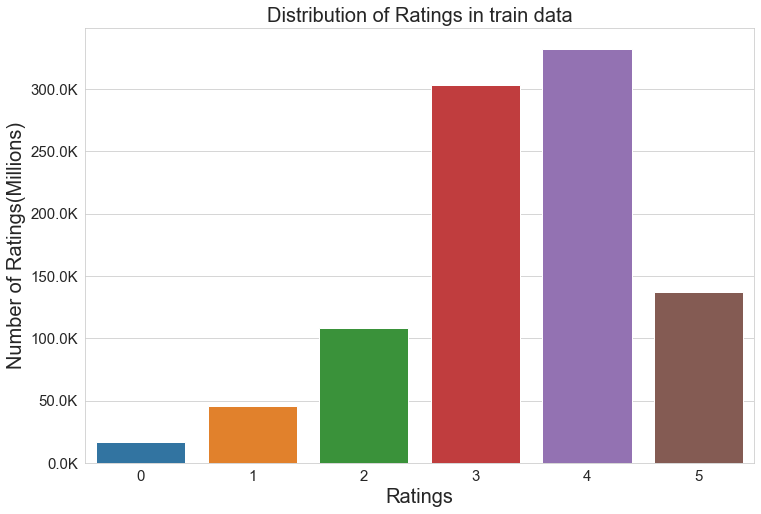

In [70]:
plt.figure(figsize = (12, 8))
ax = sns.countplot(x="Ratings", data=Train_Data)

ax.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])

plt.tick_params(labelsize = 15)
plt.title("Distribution of Ratings in train data", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings(Millions)", fontsize = 20)
plt.show()

In [71]:
Train_Data["DayOfWeek"] = Train_Data.Date.dt.weekday

In [72]:
Train_Data.head()

,CustID,MovieID,Ratings,Date,DayOfWeek
528101,5358,19,1,1996-01-30,1
997463,10031,221,5,1996-03-02,5
463817,4769,250,3,1996-03-02,5
463818,4769,258,4,1996-03-02,5
463827,4769,353,4,1996-03-02,5


### Number of Ratings per month

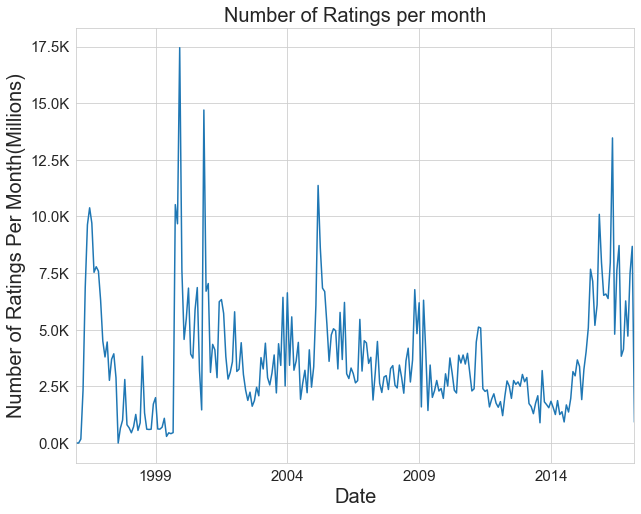

In [73]:
plt.figure(figsize = (10,8))
ax = Train_Data.resample("M", on = "Date")["Ratings"].count().plot()
#this above resample() function is a sort of group-by operation.Resample() function can work with dates. It can take months,
#days and years values independently. Here, in parameter we have given "M" which means it will group all the rows Monthly using 
#"Date" which is already present in the DataFrame. Now after grouping the rows month wise, we have just counted the ratings 
#which are grouped by months and plotted them. So, below plot shows that how many ratings are there per month. 
#In resample(), we can also give "6M" for grouping the rows every 6-Monthly, we can also give "Y" for grouping
#the rows yearly, we can also give "D" for grouping the rows by day.
#Resample() is a function which is designed to work with time and dates.
#This "Train_Data.resample("M", on = "Date")["Ratings"].count()" returns a pandas series where keys are Dates and values are 
#counts of ratings grouped by months.You can even check it and print it. Then we are plotting it, where it automatically takes
#Dates--which are keys on--x-axis and counts--which are values on--y-axis.
ax.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])
ax.set_title("Number of Ratings per month", fontsize = 20)
ax.set_xlabel("Date", fontsize = 20)
ax.set_ylabel("Number of Ratings Per Month(Millions)", fontsize = 20)
plt.tick_params(labelsize = 15)
plt.show()

### Analysis of Ratings given by user

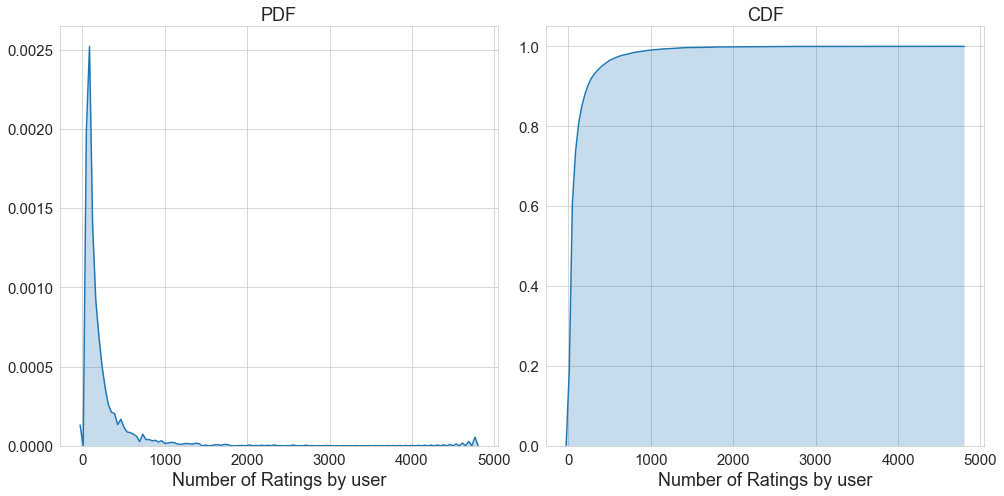

In [74]:
no_of_rated_movies_per_user = Train_Data.groupby(by = "CustID")["Ratings"].count().sort_values(ascending = False)

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(14,7))

sns.kdeplot(no_of_rated_movies_per_user.values, shade = True, ax = axes[0])
axes[0].set_title("PDF", fontsize = 18)
axes[0].set_xlabel("Number of Ratings by user", fontsize = 18)
axes[0].tick_params(labelsize = 15)

sns.kdeplot(no_of_rated_movies_per_user.values, shade = True, cumulative = True, ax = axes[1])
axes[1].set_title("CDF", fontsize = 18)
axes[1].set_xlabel("Number of Ratings by user", fontsize = 18)
axes[1].tick_params(labelsize = 15)

fig.subplots_adjust(wspace=2)
plt.tight_layout()
plt.show()

In [75]:
print("Information about movie ratings grouped by users:")
no_of_rated_movies_per_user.describe()

Information about movie ratings grouped by users:


count    9846.000000
mean       95.845115
std       197.300351
min         1.000000
25%        15.000000
50%        30.000000
75%        92.000000
max      4774.000000
Name: Ratings, dtype: float64

In [76]:
quantiles = no_of_rated_movies_per_user.quantile(np.arange(0,1.01,0.01))
# step of 0.01 from 0 to 1
quantiles

0.00       1.00
0.01       1.00
0.02       2.00
0.03       3.00
0.04       3.00
         ...   
0.96     467.20
0.97     553.95
0.98     713.40
0.99     968.10
1.00    4774.00
Name: Ratings, Length: 101, dtype: float64

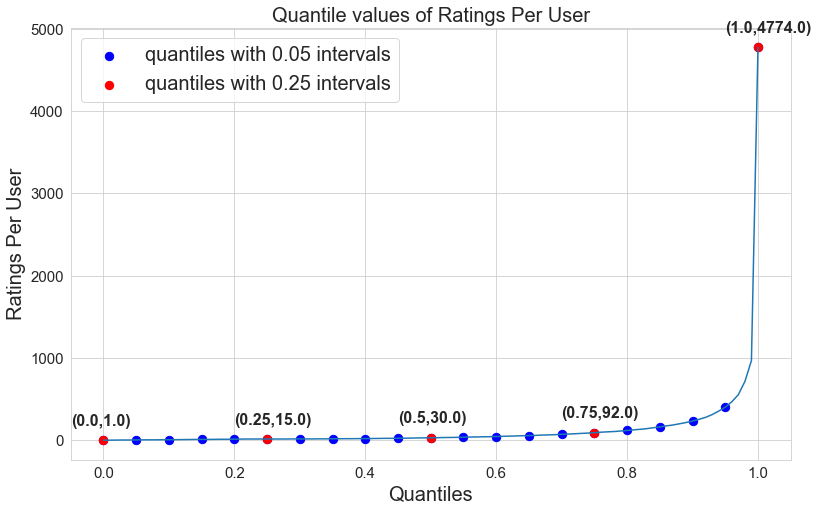

In [77]:
fig = plt.figure(figsize = (10, 6))

axes = fig.add_axes([0.1,0.1,1,1])
axes.set_title("Quantile values of Ratings Per User", fontsize = 20)
axes.set_xlabel("Quantiles", fontsize = 20)
axes.set_ylabel("Ratings Per User", fontsize = 20)
axes.plot(quantiles)

plt.scatter(x = quantiles.index[::5], y = quantiles.values[::5], c = "blue", s = 70, label="quantiles with 0.05 intervals")
plt.scatter(x = quantiles.index[::25], y = quantiles.values[::25], c = "red", s = 70, label="quantiles with 0.25 intervals")
plt.legend(loc='upper left', fontsize = 20)

for x, y in zip(quantiles.index[::25], quantiles.values[::25]):
    plt.annotate(s = '({},{})'.format(x, y), xy = (x, y), fontweight='bold', fontsize = 16, xytext=(x-0.05, y+180))
    
axes.tick_params(labelsize = 15)

### Analysis of Ratings Per Movie

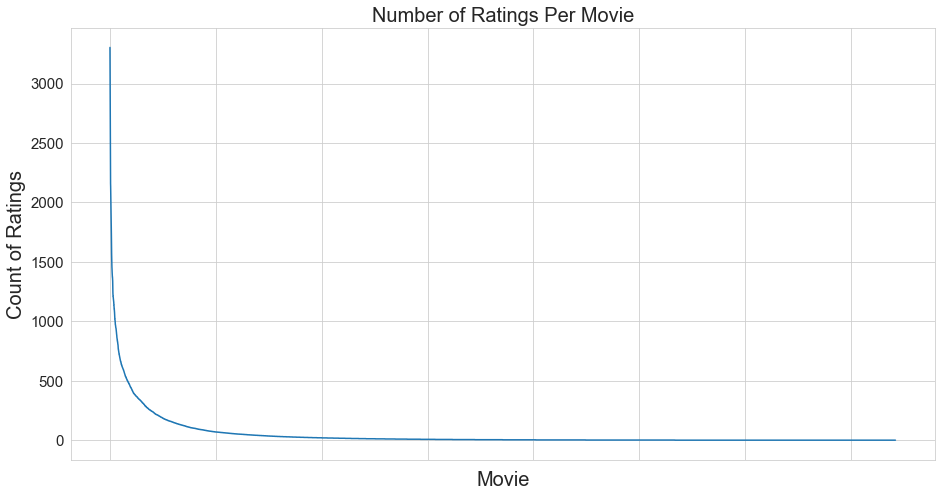

In [78]:
no_of_ratings_per_movie = Train_Data.groupby(by = "MovieID")["Ratings"].count().sort_values(ascending = False)

fig = plt.figure(figsize = (12, 6))
axes = fig.add_axes([0.1,0.1,1,1])
plt.title("Number of Ratings Per Movie", fontsize = 20)
plt.xlabel("Movie", fontsize = 20)
plt.ylabel("Count of Ratings", fontsize = 20)
plt.plot(no_of_ratings_per_movie.values)
plt.tick_params(labelsize = 15)
axes.set_xticklabels([])
plt.show()

It clearly shows that there are some movies which are very popular and were rated by many users as comapared to other movies



### Analysis of Movie Ratings on Day of Week

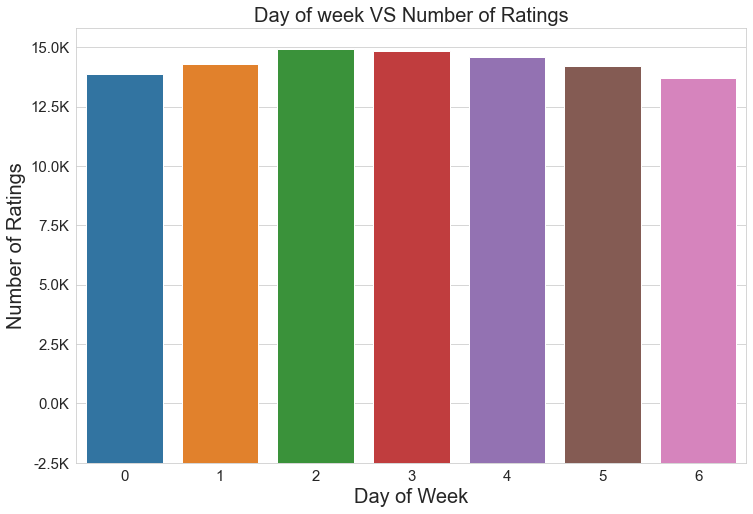

In [79]:

fig = plt.figure(figsize = (12, 8))

axes = sns.countplot(x = "DayOfWeek", data = Train_Data)
axes.set_title("Day of week VS Number of Ratings", fontsize = 20)
axes.set_xlabel("Day of Week", fontsize = 20)
axes.set_ylabel("Number of Ratings", fontsize = 20)
axes.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])
axes.tick_params(labelsize = 15)

plt.show()

## 3. Creating USER-ITEM sparse matrix from data frame

In [80]:

startTime = datetime.now()
print("Creating USER_ITEM sparse matrix for train Data")
if os.path.isfile("../Data/TrainUISparseData.npz"):
    print("Sparse Data is already present in your disk, no need to create further. Loading Sparse Matrix")
    TrainUISparseData = sparse.load_npz("../Data/TrainUISparseData.npz")
    print("Shape of Train Sparse matrix = "+str(TrainUISparseData.shape))
    
else:
    print("We are creating sparse data")
    TrainUISparseData = sparse.csr_matrix((Train_Data.Ratings, (Train_Data.CustID, Train_Data.MovieID)))
    print("Creation done. Shape of sparse matrix = "+str(TrainUISparseData.shape))
    print("Saving it into disk for furthur usage.")
    sparse.save_npz("TrainUISparseData.npz", TrainUISparseData)
    print("Done\n")

print(datetime.now() - startTime)

Creating USER_ITEM sparse matrix for train Data
We are creating sparse data
Creation done. Shape of sparse matrix = (10533, 47125)
Saving it into disk for furthur usage.
Done

0:00:00.623296


In [81]:
startTime = datetime.now()
print("Creating USER_ITEM sparse matrix for test Data")
if os.path.isfile("../Data/TestUISparseData.npz"):
    print("Sparse Data is already present in your disk, no need to create further. Loading Sparse Matrix")
    TestUISparseData = sparse.load_npz("../Data/TestUISparseData.npz")
    print("Shape of Test Sparse Matrix = "+str(TestUISparseData.shape))
else:
    print("We are creating sparse data")
    TestUISparseData = sparse.csr_matrix((Test_Data.Ratings, (Test_Data.CustID, Test_Data.MovieID)))
    print("Creation done. Shape of sparse matrix = "+str(TestUISparseData.shape))
    print("Saving it into disk for furthur usage.")
    sparse.save_npz("TestUISparseData.npz", TestUISparseData)
    print("Done\n")

print(datetime.now() - startTime)

Creating USER_ITEM sparse matrix for test Data
We are creating sparse data
Creation done. Shape of sparse matrix = (10528, 58087)
Saving it into disk for furthur usage.
Done

0:00:00.086771


In [82]:
Test_Data.CustID.nunique()

941

In [83]:
#If you can see above that the shape of both train and test sparse matrices are different, furthermore, how come this shape of sparse
#matrix has arrived:
#Shape of sparse matrix depends on highest value of User ID and highest value of Movie ID. 
#Now the user whose user ID is highest is present in  test data and not in train data. Similarly, the movie whose movie ID is
#highest is present in test data and not in train data. Hence, shape of both train and test sparse matrices are different.

In [84]:
rows,cols = TrainUISparseData.shape
presentElements = TrainUISparseData.count_nonzero()

print("Sparsity Of Train matrix : {}% ".format((1-(presentElements/(rows*cols)))*100))

Sparsity Of Train matrix : 99.81327126240355% 


## 4. Finding Global average of all movie ratings, Average rating per user, and Average rating per movie

In [85]:
def getAverageRatings(sparseMatrix, if_user):
    ax = 1 if if_user else 0
    #axis = 1 means rows and axis = 0 means columns 
    sumOfRatings = sparseMatrix.sum(axis = ax).A1  #this will give an array of sum of all the ratings of user if axis = 1 else 
    #sum of all the ratings of movies if axis = 0
    noOfRatings = (sparseMatrix!=0).sum(axis = ax).A1  #this will give a boolean True or False array, and True means 1 and False 
    #means 0, and further we are summing it to get the count of all the non-zero cells means length of non-zero cells
    rows, cols = sparseMatrix.shape
    averageRatings = {i: sumOfRatings[i]/noOfRatings[i] for i in range(rows if if_user else cols) if noOfRatings[i]!=0}
    return averageRatings

### Global Average Rating

In [86]:
Global_Average_Rating = TrainUISparseData.sum()/TrainUISparseData.count_nonzero()
print("Global Average Rating {}".format(Global_Average_Rating))

Global Average Rating 3.4403367926798083


### Average Rating Per User

In [87]:
AvgRatingUser = getAverageRatings(TrainUISparseData, True)
print("Average rating of user 25 = {}".format(AvgRatingUser[25]))

Average rating of user 25 = 3.75


### Average Rating Per Movie

In [88]:
AvgRatingMovie = getAverageRatings(TrainUISparseData, False)
print("Average rating of movie 4500 = {}".format(AvgRatingMovie[4500]))


Average rating of movie 4500 = 2.9


### PDF and CDF of Average Ratings of Users and Movies¶


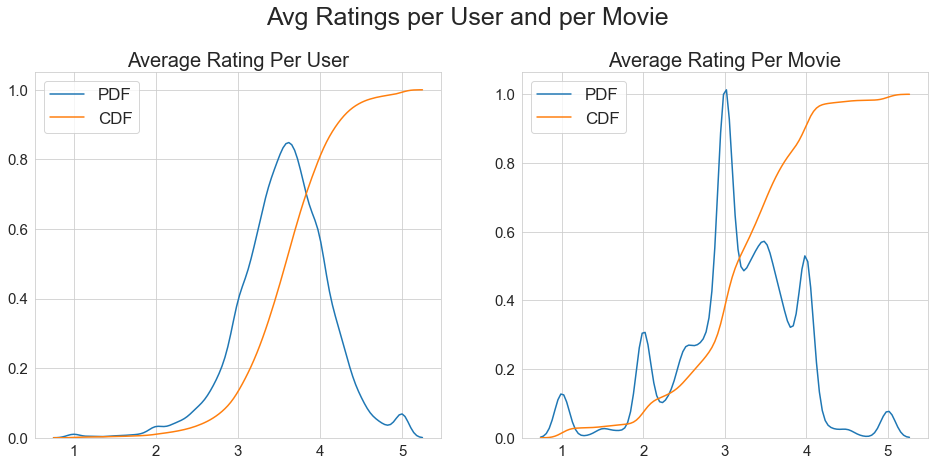

In [89]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 7))
fig.suptitle('Avg Ratings per User and per Movie', fontsize=25)

user_average = [rats for rats in AvgRatingUser.values()]
sns.distplot(user_average, hist = False, ax = axes[0], label = "PDF")
sns.kdeplot(user_average, cumulative = True, ax = axes[0], label = "CDF")
axes[0].set_title("Average Rating Per User", fontsize=20)
axes[0].tick_params(labelsize = 15)
axes[0].legend(loc='upper left', fontsize = 17)

movie_average = [ratm for ratm in AvgRatingMovie.values()]
sns.distplot(movie_average, hist = False, ax = axes[1], label = "PDF")
sns.kdeplot(movie_average, cumulative = True, ax = axes[1], label = "CDF")
axes[1].set_title("Average Rating Per Movie", fontsize=20)
axes[1].tick_params(labelsize = 15)
axes[1].legend(loc='upper left', fontsize = 17)

plt.subplots_adjust(wspace=0.2, top=0.85)
plt.show()

### Cold Start Problem


With recommendation engines, the “cold start” simply means that the circumstances are not yet optimal for the engine to provide the best possible results. Specifically, it concerns the issue that the system cannot draw any inferences for users or items about which it has not yet gathered sufficient information.

#### Cold Start Problem with Users


In [90]:
total_users = len(np.unique(Final_Data["CustID"]))
train_users = len(AvgRatingUser)
uncommonUsers = total_users - train_users
                  
print("Total number of Users = {}".format(total_users))
print("Number of Users in train data= {}".format(train_users))
print("Number of Users not present in train data = {}({}%)".format(uncommonUsers, np.round((uncommonUsers/total_users)*100), 2))

Total number of Users = 10532
Number of Users in train data= 9828
Number of Users not present in train data = 704(7.0%)


#### Cold Start Problem with Movies


In [91]:
total_movies = len(np.unique(Final_Data["MovieID"]))
train_movies = len(AvgRatingMovie)
uncommonMovies = total_movies - train_movies
                  
print("Total number of Movies = {}".format(total_movies))
print("Number of Movies in train data= {}".format(train_movies))
print("Number of Movies not present in train data = {}({}%)".format(uncommonMovies, np.round((uncommonMovies/total_movies)*100), 2))

Total number of Movies = 22147
Number of Movies in train data= 17463
Number of Movies not present in train data = 4684(21.0%)


## 5. Computing Similarity Matrices


In [92]:
arr=np.array([[1,0,1],[1,1,1],[1,1,1],[0,0,0],[1,0,0]])

In [93]:
arr.shape

(5, 3)

In [94]:
TrainUISparseData.shape

(10533, 47125)

In [95]:
cosine_similarity(arr.T)

array([[1.        , 0.70710678, 0.8660254 ],
       [0.70710678, 1.        , 0.81649658],
       [0.8660254 , 0.81649658, 1.        ]])

In [96]:
# This works by computing similarity as the normalized dot product 

#### Computing User-User Similarity Matrix for 100 users only


In [97]:
row_index, col_index = TrainUISparseData.nonzero()
rows = np.unique(row_index)
for i in rows[:100]:
    pass
    
print(i)

104


In [98]:
#Here, we are calculating user-user similarity matrix only for first 100 users in our sparse matrix. And we are calculating 
#top 100 most similar users with them.
def getUser_UserSimilarity(sparseMatrix, top = 100):
    startTimestamp20 = datetime.now()  
    
    row_index, col_index = sparseMatrix.nonzero()  #this will give indices of rows in "row_index" and indices of columns in 
    #"col_index" where there is a non-zero value exist.
    rows = np.unique(row_index)
    similarMatrix = np.zeros(10500).reshape(105,100)    #  As we are building similarity matrix only 
    #for top 100 most similar users USERID till 105 is giving us 100 users
    timeTaken = []
    howManyDone = 0
    for row in rows[:top]:
        howManyDone += 1
        startTimestamp = datetime.now().timestamp()  #it will give seconds elapsed
        sim = cosine_similarity(sparseMatrix.getrow(row), sparseMatrix).ravel()
        top100_similar_indices = sim.argsort()[-top:]
        top100_similar = sim[top100_similar_indices]
        similarMatrix[row] = top100_similar
        timeforOne = datetime.now().timestamp() - startTimestamp
        timeTaken.append(timeforOne)
        if howManyDone % 20 == 0:
            print("Time elapsed for {} users = {}sec".format(howManyDone, (datetime.now() - startTimestamp20)))
    print("Average Time taken to compute similarity matrix for 1 user = "+str(sum(timeTaken)/len(timeTaken))+"seconds")
    
    fig = plt.figure(figsize = (12,8))
    plt.plot(timeTaken, label = 'Time Taken For Each User')
    plt.plot(np.cumsum(timeTaken), label='Cumulative Time')
    plt.legend(loc='upper left', fontsize = 15)
    plt.xlabel('Users', fontsize = 20)
    plt.ylabel('Time(Seconds)', fontsize = 20)
    plt.tick_params(labelsize = 15)
    plt.show()
    
    return similarMatrix

Time elapsed for 20 users = 0:00:00.858703sec
Time elapsed for 40 users = 0:00:01.729137sec
Time elapsed for 60 users = 0:00:02.513106sec
Time elapsed for 80 users = 0:00:03.288003sec
Time elapsed for 100 users = 0:00:04.084024sec
Average Time taken to compute similarity matrix for 1 user = 0.04034111022949219seconds


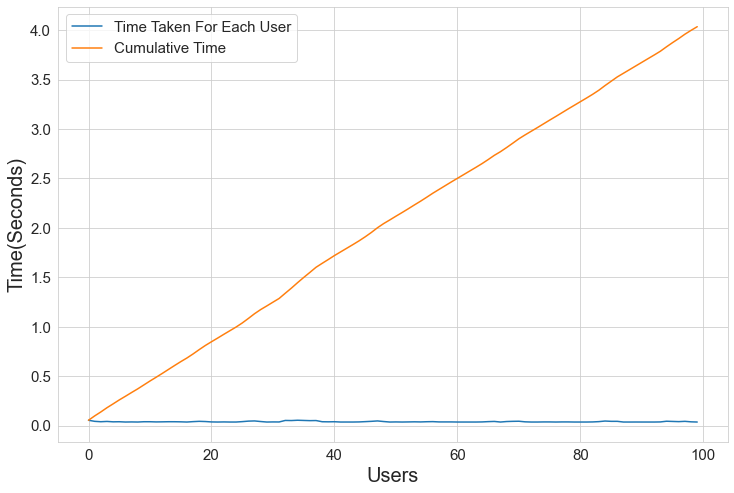

In [99]:
simMatrix = getUser_UserSimilarity(TrainUISparseData, 100)

In [100]:
# here which ever number of USERID is not present we have all 0 in their similarity, Example see the above cell "i" values in rows

simMatrix[96]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

#### Computing User-User Similarity Matrix for all


In [101]:
u_u_similarity = cosine_similarity(TrainUISparseData, dense_output = False)
print("Done")
print("Dimension of Matrix = {}".format(u_u_similarity.shape))
#sparse.save_npz("m_m_similarity.npz", u_u_similarity)

Done
Dimension of Matrix = (10533, 10533)


#### Computing Movie-Movie Similarity Matrix


In [102]:
m_m_similarity = cosine_similarity(TrainUISparseData.T, dense_output = False)
print("Done")
print("Dimension of Matrix = {}".format(m_m_similarity.shape))
#sparse.save_npz("m_m_similarity.npz", m_m_similarity)

Done
Dimension of Matrix = (47125, 47125)


In [103]:
TrainUISparseData.T.shape

(47125, 10533)

#### Let's pick random movie and check it's top 10 most similar movies.

In [104]:
movie_ids = np.unique(m_m_similarity.nonzero())


In [105]:
similar_movies_dict = dict()
for movie in movie_ids:
    smlr = np.argsort(-m_m_similarity[movie].toarray().ravel())[1:100]
    similar_movies_dict[movie] = smlr

In [106]:
movie_titles_df = pd.read_csv("movies.csv", index_col="movieId" , encoding = "iso8859_2")

In [107]:
movie_titles_df.head()

,title,Year,genres
movieId,,,
1,Toy Story (1995),1995,Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),1995.00,Adventure|Children|Fantasy
3,Grumpier Old Men (1995),1995,Comedy|Romance
4,Waiting to Exhale (1995),1995,Comedy|Drama|Romance
5,Father of the Bride Part II (1995),1995,Comedy


In [108]:
movieID_GR = 2

print("Name of the movie -------> "+str(movie_titles_df.loc[movieID_GR][0]))

print("No of ratings for movie {} is {}".format(movie_titles_df.loc[movieID_GR][0], TrainUISparseData[:,movieID_GR].getnnz()))

print("No of similar movies to {} is {}".format(movie_titles_df.loc[movieID_GR][0], m_m_similarity[movieID_GR].count_nonzero()))

Name of the movie -------> Jumanji (1995)
No of ratings for movie Jumanji (1995) is 948
No of similar movies to Jumanji (1995) is 13028


In [109]:
len(Train_Data[Train_Data["MovieID"]==2])

948

In [110]:
all_similar = m_m_similarity[movieID_GR].toarray().ravel()

similar_indices_100 = all_similar.argsort()[::-1][:101]

In [111]:
movie_titles_df.loc[similar_indices_100][["title","genres"]].head(10)

,title,genres
movieId,,
2,Jumanji (1995),Adventure|Children|Fantasy
361,"Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical|IMAX
364,"Mask, The (1994)",Action|Comedy|Crime|Fantasy
497,Mrs. Doubtfire (1993),Comedy|Drama
581,Home Alone (1990),Children|Comedy
477,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
583,Aladdin (1992),Adventure|Animation|Children|Comedy|Musical
582,Ghost (1990),Comedy|Drama|Fantasy|Romance|Thriller
374,Speed (1994),Action|Romance|Thriller


In [112]:
TrainUISparseData.shape

(10533, 47125)

## 6. Machine Learning Models


In [113]:
def get_sample_sparse_matrix(sparseMatrix, n_users, n_movies):
    # sparse.find returns tuple(I,J,V) contain the row indices, column indices, and values of the nonzero matrix entries
    users, movies, ratings = sparse.find(sparseMatrix)
    
    uniq_users = np.unique(users)
    uniq_movies = np.unique(movies)
    
    #print (len(uniq_users))
    np.random.seed(15)   #this will give same random number everytime, without replacement
    
    userS = np.random.choice(uniq_users, n_users, replace = False)
    movieS = np.random.choice(uniq_movies, n_movies, replace = False)
    
    mask = np.logical_and(np.isin(users, userS), np.isin(movies, movieS))
    sparse_sample = sparse.csr_matrix((ratings[mask], (users[mask], movies[mask])), 
                                                     shape = (max(userS)+1, max(movieS)+1))

    print("Shape of Sparse Sampled Matrix = "+str(sparse_sample.shape))
    
    #print(sparse_sample.toarray())
    return (sparse_sample)

In [114]:
# EXAMPLE

A = csr_matrix([[7.0, 8.0, 0],[0, 0, 0],[0, 4, 5],[1, 0, 5]])
print (find(A))
print ("\n")
print (get_sample_sparse_matrix(A, 2, 1))

(array([0, 3, 0, 2, 2, 3], dtype=int32), array([0, 0, 1, 1, 2, 2], dtype=int32), array([7., 1., 8., 4., 5., 5.]))


Shape of Sparse Sampled Matrix = (4, 3)
  (2, 2)	5.0
  (3, 2)	5.0


In [115]:
# EXAMPLE

element = 2*np.arange(4).reshape((2, 2))
print (element)
test_elements = [1, 2, 4, 8]
mask = np.isin(element, test_elements)
print(mask)

print(element[mask])

[[0 2]
 [4 6]]
[[False  True]
 [ True False]]
[2 4]


#### Creating Sample Sparse Matrix for Train and Test Data


In [142]:
train_sample_sparse = get_sample_sparse_matrix(TrainUISparseData, 7000, 700)
test_sample_sparse = get_sample_sparse_matrix(TestUISparseData, 900, 200)

Shape of Sparse Sampled Matrix = (10533, 46956)
Shape of Sparse Sampled Matrix = (10528, 56832)


#### Finding Global Average of all movie ratings, Average rating per User, and Average rating per Movie (from sampled train)


In [143]:
print("Global average of all movies ratings in Train Sample Sparse is {}".format(np.round((train_sample_sparse.sum()/train_sample_sparse.count_nonzero()), 2)))

Global average of all movies ratings in Train Sample Sparse is 3.39


In [144]:
globalAvgMovies = getAverageRatings(train_sample_sparse, False)
print("Average movie rating for movie 74 is {}".format(globalAvgMovies[74]))

Average movie rating for movie 74 is 3.3333333333333335


In [145]:
globalAvgUsers = getAverageRatings(train_sample_sparse, True)
print("Average user rating for user 2393 is {}".format(globalAvgUsers[2393]))

Average user rating for user 2393 is 4.75


In [146]:
print ("Shape of Sampled train matrix is : {}".format(train_sample_sparse.shape))
print("No of ratings in Our Sampled train matrix is : {}".format(train_sample_sparse.count_nonzero()))
print ("\n")
print ("Shape of Sampled test matrix is : {}".format(test_sample_sparse.shape))
print("No of ratings in Our Sampled test matrix is : {}".format(test_sample_sparse.count_nonzero()))

Shape of Sampled train matrix is : (10533, 46956)
No of ratings in Our Sampled train matrix is : 24508


Shape of Sampled test matrix is : (10528, 56832)
No of ratings in Our Sampled test matrix is : 1534


#### Featurizing Train Data


In [147]:
sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(train_sample_sparse)

total_list=[]
for user, movie, rating in zip(sample_train_users, sample_train_movies, sample_train_ratings):
    row = list()
    row.append(user)  #appending user ID
    row.append(movie) #appending movie ID
    row.append(train_sample_sparse.sum()/train_sample_sparse.count_nonzero()) #appending global average rating

#----------------------------------Ratings given to "movie" by top 5 similar users with "user"--------------------#
    similar_users = cosine_similarity(train_sample_sparse[user], train_sample_sparse).ravel()
    similar_users_indices = np.argsort(-similar_users)[1:]
    similar_users_ratings = train_sample_sparse[similar_users_indices, movie].toarray().ravel()
    top_similar_user_ratings = list(similar_users_ratings[similar_users_ratings != 0][:5])
    top_similar_user_ratings.extend([globalAvgMovies[movie]]*(5-len(top_similar_user_ratings)))
    #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "movie" average
    #rating. Let say only 3 out of 5 ratings are available then rest 2 will be "movie" average rating.
    row.extend(top_similar_user_ratings)

#----------------------------------Ratings given by "user" to top 5 similar movies with "movie"------------------#
    similar_movies = cosine_similarity(train_sample_sparse[:,movie].T, train_sample_sparse.T).ravel()
    similar_movies_indices = np.argsort(-similar_movies)[1:]
    similar_movies_ratings = train_sample_sparse[user, similar_movies_indices].toarray().ravel()
    top_similar_movie_ratings = list(similar_movies_ratings[similar_movies_ratings != 0][:5])
    top_similar_movie_ratings.extend([globalAvgUsers[user]]*(5-len(top_similar_movie_ratings)))
    #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "user" average
    #rating. Let say only 3 out of 5 ratings are available then rest 2 will be "user" average rating.
    row.extend(top_similar_movie_ratings)

#----------------------------------Appending "user" average, "movie" average & rating of "user""movie"-----------#
    row.append(globalAvgUsers[user])
    row.append(globalAvgMovies[movie])
    row.append(rating)

    total_list.append(row)
    
    

In [148]:
Train_Reg=pd.DataFrame(total_list,columns = ["User_ID", "Movie_ID", "Global_Average", "SUR1", "SUR2", "SUR3", "SUR4", "SUR5", "SMR1", "SMR2", "SMR3", "SMR4", "SMR5", "User_Average", "Movie_Average", "Rating"])

#### Featurizing Test Data


In [150]:
sample_test_users, sample_test_movies, sample_test_ratings = sparse.find(test_sample_sparse)

total_list=[]
for user, movie, rating in zip(sample_test_users, sample_test_movies, sample_test_ratings):
    row=list()

    row.append(user)  #appending user ID
    row.append(movie) #appending movie ID
    row.append(round(test_sample_sparse.sum()/test_sample_sparse.count_nonzero(),2)) #appending global average rating
    #print (len(row))
    try:
        similar_users = cosine_similarity(train_sample_sparse[user], train_sample_sparse).ravel()
        similar_users_indices = np.argsort(-similar_users)[1:]
        similar_users_ratings = train_sample_sparse[similar_users_indices, movie].toarray().ravel()
        top_similar_user_ratings = list(similar_users_ratings[similar_users_ratings != 0][:5])
        top_similar_user_ratings.extend([globalAvgMovies[movie]]*(5-len(top_similar_user_ratings)))
        #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "movie" 
        #average rating. Let say only 3 out of 5 ratings are available then rest 2 will be "movie" average rating.
        row.extend(top_similar_user_ratings)
        
    #########Cold Start Problem, for a new user or a new movie#########    
    except(IndexError, KeyError):
        global_average_train_rating = [train_sample_sparse.sum()/train_sample_sparse.count_nonzero()]*5
        row.extend(global_average_train_rating)
    except:
        raise

#-----------------------------Ratings given by "user" to top 5 similar movies with "movie"-----------------------#
    try:
        similar_movies = cosine_similarity(train_sample_sparse[:,movie].T, train_sample_sparse.T).ravel()
        similar_movies_indices = np.argsort(-similar_movies)[1:]
        similar_movies_ratings = train_sample_sparse[user, similar_movies_indices].toarray().ravel()
        top_similar_movie_ratings = list(similar_movies_ratings[similar_movies_ratings != 0][:5])
        top_similar_movie_ratings.extend([globalAvgUsers[user]]*(5-len(top_similar_movie_ratings)))
        #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "user" 
        #average rating. Let say only 3 out of 5 ratings are available then rest 2 will be "user" average rating.
        row.extend(top_similar_movie_ratings)
        
    #########Cold Start Problem, for a new user or a new movie#########    
    except(IndexError, KeyError):
        global_average_train_rating = [train_sample_sparse.sum()/train_sample_sparse.count_nonzero()]*5
        row.extend(global_average_train_rating)
        
    except:
        raise

#-----------------------------Appending "user" average, "movie" average & rating of "user""movie"----------------#
    try:        
        row.append(globalAvgUsers[user])
    except (KeyError):
        global_average_train_rating = train_sample_sparse.sum()/train_sample_sparse.count_nonzero()
        row.append(global_average_train_rating)
    except:
        raise

    try:
        row.append(globalAvgMovies[movie])
    except(KeyError):
        global_average_train_rating = train_sample_sparse.sum()/train_sample_sparse.count_nonzero()
        row.append(global_average_train_rating)
    except:
        raise

    row.append(rating)
    total_list.append(row)
    

In [151]:
Test_Reg=pd.DataFrame(total_list,columns = ["User_ID", "Movie_ID", "Global_Average", "SUR1", "SUR2", "SUR3", "SUR4", "SUR5", "SMR1", "SMR2", "SMR3", "SMR4", "SMR5", "User_Average", "Movie_Average", "Rating"])

In [173]:
Train_Reg.head()

,User_ID,Movie_ID,Global_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,User_Average,Movie_Average,Rating
Unnamed: 0,,,,,,,,,,,,,,,,
0,160,63,3.394075,3.0,3.0,1.0,3.0,1.0,4.0,3.0,3.0,2.0,5.0,3.777778,3.289157,3
1,185,63,3.394075,5.0,4.0,3.0,3.0,5.0,3.0,3.0,3.0,3.5,3.5,3.500000,3.289157,5
2,631,63,3.394075,5.0,3.0,2.0,3.0,5.0,3.0,3.0,3.0,3.0,3.0,3.000000,3.289157,3
3,750,63,3.394075,4.0,3.0,2.0,4.0,4.0,3.0,2.0,4.0,3.0,2.8,2.800000,3.289157,2
4,816,63,3.394075,4.0,3.0,5.0,4.0,4.0,3.0,3.0,3.0,3.0,3.0,3.000000,3.289157,3


In [180]:
Test_Reg.head()

,User_ID,Movie_ID,Global_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,User_Average,Movie_Average,Rating
Unnamed: 0,,,,,,,,,,,,,,,,
0,48,109,3.39,3.394075,3.394075,3.394075,3.394075,3.394075,3.394075,3.394075,3.394075,3.394075,3.394075,3.394075,3.394075,4
1,67,109,3.39,3.394075,3.394075,3.394075,3.394075,3.394075,3.394075,3.394075,3.394075,3.394075,3.394075,3.394075,3.394075,3
2,330,109,3.39,3.394075,3.394075,3.394075,3.394075,3.394075,3.394075,3.394075,3.394075,3.394075,3.394075,3.394075,3.394075,5
3,464,109,3.39,3.394075,3.394075,3.394075,3.394075,3.394075,3.394075,3.394075,3.394075,3.394075,3.394075,3.394075,3.394075,1
4,465,109,3.39,3.394075,3.394075,3.394075,3.394075,3.394075,3.394075,3.394075,3.394075,3.394075,3.394075,3.394075,3.394075,3


In [153]:
Train_Reg.to_csv("Train_reg.csv")
Test_Reg.to_csv("Test_Reg.csv")

In [154]:
Train_Reg.shape
Test_Reg.shape

(1534, 16)

In [155]:
Train_Reg=pd.read_csv("Train_Reg.csv")
Train_Reg=Train_Reg.set_index(Train_Reg.columns[0])

Test_Reg=pd.read_csv("Test_Reg.csv")
Test_Reg=Test_Reg.set_index(Test_Reg.columns[0])


In [169]:
print(Train_Reg.shape)
print(Test_Reg.shape)

(24508, 16)
(1534, 16)


**User_ID:** ID of a this User

**Movie_ID:** ID of a this Movie

**Global_Average:** Global Average Rating

**Ratings given to this Movie by top 5 similar users with this User:** (SUR1, SUR2, SUR3, SUR4, SUR5)

**Ratings given by this User to top 5 similar movies with this Movie:** (SMR1, SMR2, SMR3, SMR4, SMR5)

**User_Average:** Average Rating of this User

**Movie_Average:** Average Rating of this Movie

**Rating:** Rating given by this User to this Movie

### Transforming Data for Surprise Models


Surprise is a Python scikit for building and analyzing recommender systems that deal with explicit rating data.

Provide various ready-to-use prediction algorithms such as baseline algorithms, neighborhood methods, matrix factorization-based ( SVD, PMF, SVD++, NMF), and many others. Also, various similarity measures (cosine, MSD, pearson…) are built-in.

**NormalPredictor:** a baseline model that predicts a random rating based on the distribution of the training set, which is assumed to be normal.\
**SVD:** A matrix factorization technique popularized by Simon Funk as part of the Netflix prize.\
**KNNBasic:** leverages cosine similarity (or user-determined distance metric) to perform KNN.\
**CoClustering:** an algorithm that assigns points to clusters in a similar method to k-means.

#### Transforming train data

- We can’t give raw data (movie, user, rating) to train the model in Surprise library.\
- They have a separate format for TRAIN and TEST data, which will be useful for training the models like SVD, KNNBaseLineOnly….etc..,in Surprise.\
- We can form the trainset from a file, or from a Pandas DataFrame. http://surprise.readthedocs.io/en/stable/getting_started.html#load-dom-dataframe-py

In [157]:
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(Train_Reg[['User_ID', 'Movie_ID', 'Rating']], reader)

trainset_data = data.build_full_trainset()

#### Transforming test data

Testset is just a list of (user, movie, rating) tuples. (Order in the tuple is important)

In [158]:
testset_data = list(zip(Test_Reg["User_ID"].values, Test_Reg["Movie_ID"].values, Test_Reg["Rating"].values))

testset_data[:5]

[(48, 109, 4), (67, 109, 3), (330, 109, 5), (464, 109, 1), (465, 109, 3)]

**Applying Machine Learning Models**\
We have two Error Metrics.

- **RMSE**: Root Mean Square Error: RMSE is the error of each point which is squared. Then mean is calculated. Finally root of that mean is taken as final value.

- **MAPE**: Mean Absolute Percentage Error: The mean absolute percentage error (MAPE), also known as mean absolute percentage deviation (MAPD), is a measure of prediction accuracy of a forecasting method.

where At is the actual value and Ft is the forecast value.

The difference between At and Ft is divided by the actual value At again. The absolute value in this calculation is summed for every forecasted point in time and divided by the number of fitted points n. Multiplying by 100% makes it a percentage error.

Global dictionary that stores RMSE and MAPE for all the models.
It stores the metrics in a dictionary of dictionaries.\
keys : model names(string)\
value: dict(key : metric, value : value )

In [159]:
error_table = pd.DataFrame(columns = ["Model", "Train RMSE", "Train MAPE", "Test RMSE", "Test MAPE"])
model_train_evaluation = dict()
model_test_evaluation = dict()

In [160]:
def make_table(model_name, rmse_train, mape_train, rmse_test, mape_test):
    global error_table
    #https://www.programiz.com/python-programming/global-keyword
    
    error_table = error_table.append(pd.DataFrame([[model_name, rmse_train, mape_train, rmse_test, mape_test]], columns = ["Model", "Train RMSE", "Train MAPE", "Test RMSE", "Test MAPE"]))
    error_table.reset_index(drop = True, inplace = True)

### Functions for Regression Models

In [161]:
def error_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(abs((y_true - y_pred)/y_true))*100
    return rmse, mape

In [162]:
def train_test_xgboost(x_train, x_test, y_train, y_test, model_name):
    startTime = datetime.now()
    train_result = dict()
    test_result = dict()
    
    
    clf = xgb.XGBRegressor(n_estimators = 100, n_jobs=10, random_state=5)
    clf.fit(x_train, y_train)
    
    print (x_train.shape,y_train.shape)
    
    print("-"*50)
    print("TRAIN DATA")
    y_pred_train = clf.predict(x_train)
    rmse_train, mape_train = error_metrics(y_train, y_pred_train)
    print("RMSE = {}".format(rmse_train))
    print("MAPE = {}".format(mape_train))
    print("-"*50)
    train_result = {"RMSE": rmse_train, "MAPE": mape_train, "Prediction": y_pred_train}
    
    print("TEST DATA")
    y_pred_test = clf.predict(x_test)
    rmse_test, mape_test = error_metrics(y_test, y_pred_test)
    print("RMSE = {}".format(rmse_test))
    print("MAPE = {}".format(mape_test))
    print("-"*50)
    test_result = {"RMSE": rmse_test, "MAPE": mape_test, "Prediction": y_pred_test}
        
    print("Time Taken = "+str(datetime.now() - startTime))
    
    print (clf.get_booster().get_fscore())
    feature_importance(xgb, clf)
    
    #xgb.plot_importance(clf)
    
    make_table(model_name, rmse_train, mape_train, rmse_test, mape_test)
    
    return train_result, test_result

In [167]:
def feature_importance(model, clf):
    fig = plt.figure(figsize = (8, 6))
    
    model.plot_importance(clf,  height = 0.6)
    plt.xlabel("F Score", fontsize = 20)
    plt.ylabel("Features", fontsize = 20)
    plt.title("Feature Importance", fontsize = 20)
    plt.tick_params(labelsize = 15)
    
    plt.show()

### Functions for Surprise Models

In [164]:
def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    predicted = np.array([pred.est for pred in predictions])
    return actual, predicted

'''https://surprise.readthedocs.io/en/stable/getting_started.html"'''
#in surprise prediction of every data point is returned as dictionary like this:
#predictions = algo.fit(trainset).test(testset)
#"user: 196        item: 302        r_ui = 4.00   est = 4.06   {'actual_k': 40, 'was_impossible': False}"
#In this dictionary, "r_ui" is a key for actual rating and "est" is a key for predicted rating


def get_error(predictions):
    actual, predicted = get_ratings(predictions)
    rmse = np.sqrt(mean_squared_error(actual, predicted)) 
    mape = np.mean(abs((actual - predicted)/actual))*100
    return rmse, mape

In [165]:
def surprise_model(algo, trainset, testset, model_name):
    
    startTime = datetime.now()
    
    train = dict()
    test = dict()
    
    # Train the algorithm on the trainset, and predict ratings for the testset
    
    #-----------------Evaluating Train Data------------------#

    algo.fit(trainset)
    
    print("TRAIN DATA")
    train_pred = algo.test(trainset.build_testset())
    """https://surprise.readthedocs.io/en/stable/trainset.html?highlight=build#surprise.Trainset.build_testset"""
    
    train_actual, train_predicted = get_ratings(train_pred)
    train_rmse, train_mape = get_error(train_pred)
    print("RMSE = {}".format(train_rmse))
    print("MAPE = {}".format(train_mape))
    print("."*100)
    
    train = {"RMSE": train_rmse, "MAPE": train_mape, "Prediction": train_predicted}
    
    #-----------------Evaluating Test Data------------------#
    
    print("TEST DATA")
    test_pred = algo.test(testset)
    
    
    test_actual, test_predicted = get_ratings(test_pred)
    test_rmse, test_mape = get_error(test_pred)
    
    print("RMSE = {}".format(test_rmse))
    print("MAPE = {}".format(test_mape))
    print("."*100)
    
    test = {"RMSE": test_rmse, "MAPE": test_mape, "Prediction": test_predicted}
    
    print("Time Taken = "+str(datetime.now() - startTime))
    
    make_table(model_name, train_rmse, train_mape, test_rmse, test_mape)
    
    return train, test    


### 1. XGBOOST REGRESSOR

(24508, 13) (24508,)
--------------------------------------------------
TRAIN DATA
RMSE = 0.5594756739396584
MAPE = 15.77124216944571
--------------------------------------------------
TEST DATA
RMSE = 1.023452852427349
MAPE = 34.04095528074979
--------------------------------------------------
Time Taken = 0:00:00.938504
{'User_Average': 1175, 'Movie_Average': 862, 'SMR3': 435, 'SMR1': 422, 'SUR5': 257, 'SUR2': 294, 'SUR3': 307, 'SUR1': 390, 'SMR4': 456, 'SUR4': 266, 'SMR5': 475, 'SMR2': 403}


<Figure size 576x432 with 0 Axes>

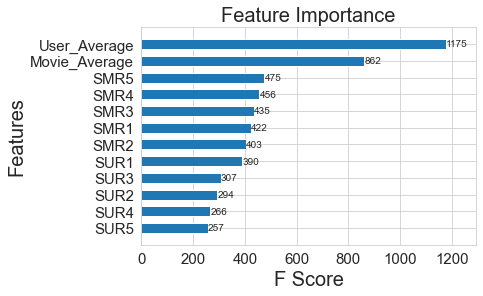

In [168]:
x_train = Train_Reg.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

x_test = Test_Reg.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

y_train = Train_Reg["Rating"]

y_test = Test_Reg["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGBoost_13")

model_train_evaluation["XGBoost_13"] = train_result
model_test_evaluation["XGBoost_13"] = test_result

### 2. Surprise BaselineOnly Model

https://towardsdatascience.com/build-a-recommender-system-yelp-rating-prediction-example-collaborative-filtering-28a6e48a8cc



Let us start by introducing a simple baseline model. An assumption this model makes is that each user has some natural bias towards ratings he gives, and hence rate businesses higher or lower in general. The model also assumes the businesses each have a higher or lower propensity to appeal to people in general. Also, the data has some underlying bias, and hence, each source of bias is included to model ratings using the following equation:

**rᵤᵢ=μ + bᵤ +bᵢ**

If user u is unknown, then the bias bu is assumed to be zero. 

Here, μ is the average rating bias, and the parameters, bᵤ and bᵢ indicate the user and item bias respectively. For example, let us say that we want to find how a user ABC, might rate ‘SHAKE SHACK BURGERS’. Let us say that the average rating of all the restaurants in the data is 3.4, and in general, ‘SHAKE SHACK BURGERS’ is a highly rated restaurant, so it is rated 0.5 higher than the average. On the other hand, ‘ABC’ is a selective user and generally rates restaurants 0.4 lower than the average. So, the baseline estimate for the user ‘ABC’ for the restaurant ‘SHAKE SHACK BURGERS’ would be 3.4 + 0.5–0.4 = 3.5. The baseline function implemented estimates bᵤ and bᵢ to optimize following loss function (*):

**∑ (rᵤᵢ − (μ + bᵤ + bᵢ))² + λ (bᵤ² + bᵢ²) where rᵤᵢ ∈ R_train, λ is regularization**



Baselines can be estimated in two different ways:

- Using Stochastic Gradient Descent (SGD).
- Using Alternating Least Squares (ALS).

You can configure the way baselines are computed using the bsl_options parameter passed at the creation of an algorithm. This parameter is a dictionary for which the key 'method' indicates the method to use. Accepted values are 'als' (default) and 'sgd'. Depending on its value, other options may be set. For ALS:

    
**'reg_i':** The regularization parameter for items.  Default is 10.\
**'reg_u':** The regularization parameter for users. Default is 15.\
**'n_epochs':** The number of iteration of the ALS procedure. Default is 10.

And for SGD:
    
**'reg':** The regularization parameter of the cost function that is optimized,  Default is 0.02.\
**'learning_rate':** The learning rate of SGD,  Default is 0.005.\
**'n_epochs':** The number of iteration of the SGD procedure. Default is 20.

In [172]:
bsl_options = {"method":"sgd", "learning_rate":0.01, "n_epochs":25}

algo = BaselineOnly(bsl_options=bsl_options)
#You can check the docs of above used functions at:https://surprise.readthedocs.io/en/stable/prediction_algorithms.html#baseline-estimates-configuration
#at section "Baselines estimates configuration".

train_result, test_result = surprise_model(algo, trainset_data, testset_data, "BaselineOnly")

model_train_evaluation["BaselineOnly"] = train_result
model_test_evaluation["BaselineOnly"] = test_result

Estimating biases using sgd...
TRAIN DATA
RMSE = 0.7981573080256933
MAPE = 25.01489596482593
....................................................................................................
TEST DATA
RMSE = 1.0086883531794724
MAPE = 32.91311847068389
....................................................................................................
Time Taken = 0:00:00.603384


### 3. XGBoost 13 Features + Surprise BaselineOnly Model

##### Adding predicted ratings from Surprise BaselineOnly model to our Train and Test Dataframe


In [182]:
Train_Reg["BaselineOnly"] = model_train_evaluation["BaselineOnly"]["Prediction"]
Test_Reg["BaselineOnly"] = model_test_evaluation["BaselineOnly"]["Prediction"]


(24508, 14) (24508,)
--------------------------------------------------
TRAIN DATA
RMSE = 0.5660910937370403
MAPE = 16.071018890729214
--------------------------------------------------
TEST DATA
RMSE = 1.054523441728424
MAPE = 36.11031378004574
--------------------------------------------------
Time Taken = 0:00:02.386168
{'User_Average': 853, 'Movie_Average': 603, 'SMR3': 300, 'SMR1': 304, 'SUR5': 207, 'SUR2': 256, 'SUR3': 207, 'SUR1': 337, 'SMR4': 330, 'SUR4': 221, 'SMR5': 368, 'SMR2': 304, 'BaselineOnly': 947}


<Figure size 576x432 with 0 Axes>

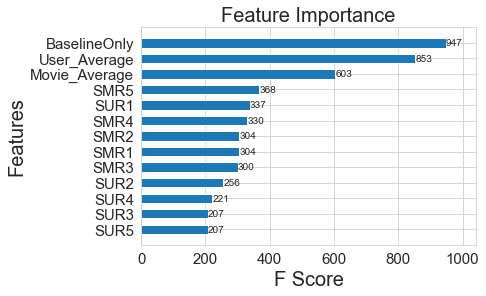

In [183]:
x_train = Train_Reg.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

x_test = Test_Reg.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

y_train = Train_Reg["Rating"]

y_test = Test_Reg["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_BSL")

model_train_evaluation["XGB_BSL"] = train_result
model_test_evaluation["XGB_BSL"] = test_result

### 4. Surprise KNN-Baseline with User-User and Item-Item Similarity

https://towardsdatascience.com/how-to-build-a-memory-based-recommendation-system-using-python-surprise-55f3257b2cf4

When we work with kNN — type recommender algorithms, there are 2 hyperparameters we can tune: 

- k parameter (yes, same k as in the name of the model type)
- similarity option

The k parameter is fairly straightforward, and analogous to how it works in general k-nearest neighbours models: it is the upper limit of similar items we want the algorithm to consider. For example, if the user rated 20 games, but we set k to 10, when we estimate a rating to a new game, only those 10 games out of 20 that are the closest to the new game will be considered. You can also set min_k, if a user does not have enough ratings, the global average will be used for estimations. As a default, it’s 1.

We mentioned items being close to each other in the previous paragraph, but how do we determine that distance? It is the second hyperparameter, the similarity option, that defines the way to calculate it.

Let’s have a look at the sim_option configuration first. This parameter is a dictionary, with the following keys:

- **shrinkage:** won’t need for basic kNN models, only comes in play with the KNNBaseline model.
- **user_based:** Basically, there are two different routes when you want to estimate similarities. You can either compute how similar each item is to each other item, or do the same with the users. For my project, I used False, considering I had 100 items and 230k users.
- **min_support:** The minimum number of common points under which the similarity will be set to 0. Example: if min_support is 10, and there are two games, only 9 users rated them both, regardless of the ratings, the two games’ similarity will be 0. I did not experiment with this in my project, did not seem to be significant considering the scope of the data, so I used the default 1.
- **name:** The type of formula, to be discussed further below.

All the similarity functions will return a number between 0 and 1 to a specific (i, j) item pair. 1 means the ratings are perfectly aligned, 0 means there is no connection between the two items. In the formulas, rᵤᵢ is the rating user u gave to item i, μᵢ is the average ratings on item i, and Uᵢⱼ is the set of users that rated both items i and j. These are the three similarity metrics in the surprise similarity module:

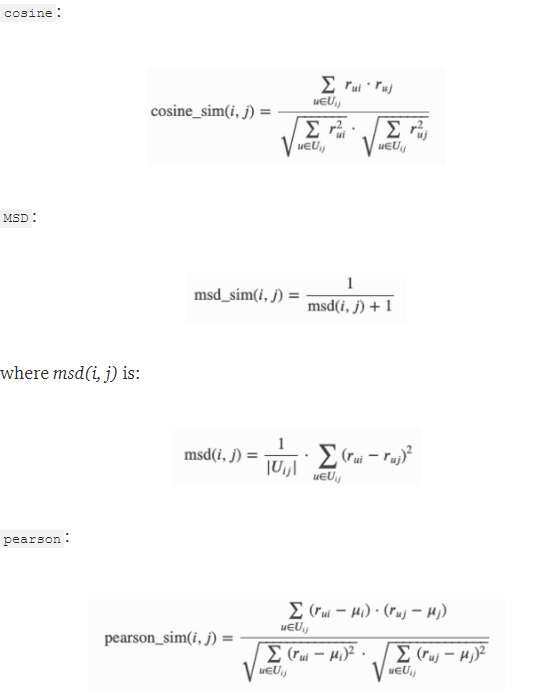



An example on how to define a sim_option parameter:
my_sim_option = {
    'name':'MSD', 'user_based':False, min_support = 1
    }
Now we did all the prep work, we can finally train some models.



#### KNN Models
There are three variations of basic KNN models in surprise. They define how rᵤᵢ , the rating user u would give to item i, is estimated in the predictions. The formulas below mostly use notations we have discussed in the previous section, a couple of new ones: σᵢ is the standard deviation of item i, Nᵤᵏ(i) is the maximum k items from the ones user u rated that are closest to item i.

Without further ado, the formulas:

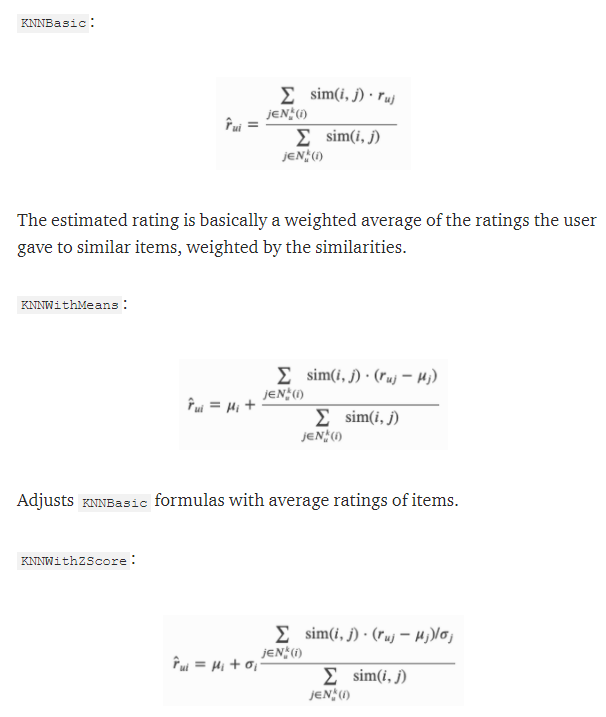


#### 4.1 Surprise KNN-Baseline with User-User

In [197]:

param_grid  = {'sim_options':{'name': ["pearson_baseline"], "user_based": [True], "min_support": [2,5], "shrinkage": [60, 80,  140]}, 'k': [5, 20, 40]}

gs = GridSearchCV(KNNBaseline, param_grid, measures=['rmse', 'mae'], cv=3,joblib_verbose=0)

gs.fit(data)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

In [198]:
# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9392885416840794
{'sim_options': {'name': 'pearson_baseline', 'user_based': True, 'min_support': 2, 'shrinkage': 60}, 'k': 40}


In [199]:
bsl_options = {"method":"sgd", "learning_rate":0.01, "n_epochs":25}

algo = KNNBaseline(k = gs.best_params['rmse']['k'], sim_options = gs.best_params['rmse']["sim_options"], bsl_options=bsl_options)

train_result, test_result = surprise_model(algo, trainset_data, testset_data, "KNNBaseline_User")

model_train_evaluation["KNNBaseline_User"] = train_result
model_test_evaluation["KNNBaseline_User"] = test_result

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
TRAIN DATA
RMSE = 0.22381473709913033
MAPE = 5.797188978433412
....................................................................................................
TEST DATA
RMSE = 1.0111013400519357
MAPE = 33.01118775905322
....................................................................................................
Time Taken = 0:00:26.103249



#### 4.2 Surprise KNN-Baseline with Movie-Movie

In [200]:
param_grid  = {'sim_options':{'name': ["pearson_baseline"], "user_based": [False], "min_support": [2,5], "shrinkage": [60, 80,  140]}, 'k': [5, 20, 40]}

gs = GridSearchCV(KNNBaseline, param_grid, measures=['rmse', 'mae'], cv=3,joblib_verbose=0)

gs.fit(data)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

In [201]:
bsl_options = {"method":"sgd", "learning_rate":0.01, "n_epochs":25}

algo = KNNBaseline(k = gs.best_params['rmse']['k'], sim_options = gs.best_params['rmse']["sim_options"], bsl_options=bsl_options)

train_result, test_result = surprise_model(algo, trainset_data, testset_data, "KNNBaseline_Movie")

model_train_evaluation["KNNBaseline_Movie"] = train_result
model_test_evaluation["KNNBaseline_Movie"] = test_result

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
TRAIN DATA
RMSE = 0.16004217785292627
MAPE = 3.7954422949548485
....................................................................................................
TEST DATA
RMSE = 1.0084763941997839
MAPE = 32.90207988477926
....................................................................................................
Time Taken = 0:00:03.270026


### 5. Matrix Factorization SVD

http://rstudio-pubs-static.s3.amazonaws.com/335300_11d40bf12d8940f78d9661b3c63150dc.html \
https://analyticsindiamag.com/singular-value-decomposition-svd-application-recommender-system/

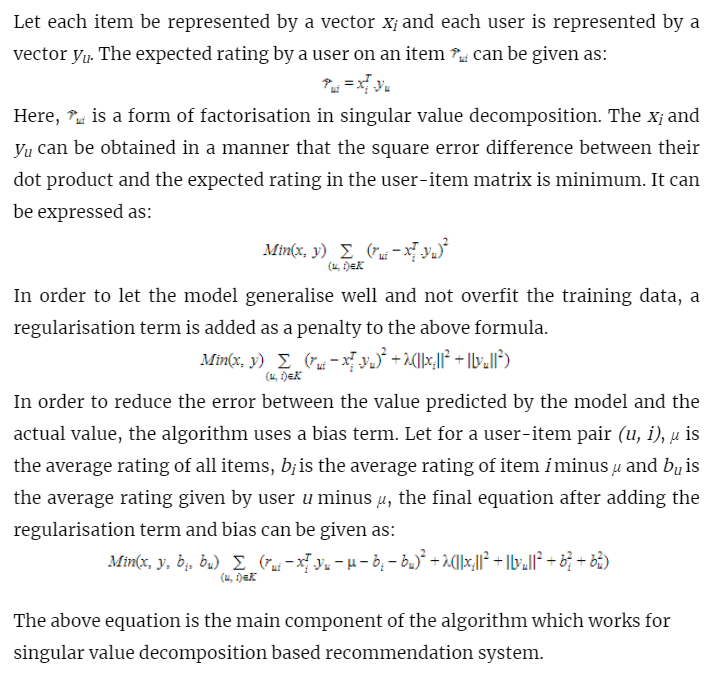

In [202]:
param_grid  = {'n_factors': [5,10,15,20,35,50,70,90]}  

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)


In [203]:

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9066910152685127
{'n_factors': 5}


In [204]:
#n_epochs – The number of iteration of the SGD procedure. Default is 20


algo = SVD(n_factors = gs.best_params['rmse']['n_factors'], biased=True, verbose=True)

train_result, test_result = surprise_model(algo, trainset_data, testset_data, "SVD")

model_train_evaluation["SVD"] = train_result
model_test_evaluation["SVD"] = test_result

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
TRAIN DATA
RMSE = 0.8204890354844693
MAPE = 26.08038638007395
....................................................................................................
TEST DATA
RMSE = 1.0066358293916313
MAPE = 32.89978643865643
....................................................................................................
Time Taken = 0:00:00.711843


### 6. Matrix Factorization SVDpp with implicit feedback

https://www.alpha-quantum.com/blog/collaborative-filtering-recommender-systems/collaborative-filtering-recommender-system-with-python-from-scratch-using-svd-item-based-model-based-approaches/

In [206]:
param_grid = {'n_factors': [10, 30, 50, 80, 100], 'lr_all': [0.002, 0.006, 0.03,  0.10]}

gs = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9022135703287016
{'n_factors': 10, 'lr_all': 0.006}


In [208]:
algo = SVDpp(n_factors = gs.best_params['rmse']['n_factors'], lr_all = gs.best_params['rmse']["lr_all"], verbose=True)

train_result, test_result = surprise_model(algo, trainset_data, testset_data, "SVDpp")

model_train_evaluation["SVDpp"] = train_result
model_test_evaluation["SVDpp"] = test_result

 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
TRAIN DATA
RMSE = 0.7548849123786409
MAPE = 23.80725213397415
....................................................................................................
TEST DATA
RMSE = 1.007089956228711
MAPE = 32.93073031221214
....................................................................................................
Time Taken = 0:00:07.428548


### 7. XGBoost 13 Features + Surprise BaselineOnly + Surprise KNN Baseline + SVD + SVDpp

In [214]:
Train_Reg["SVD"] = model_train_evaluation["SVD"]["Prediction"]
Train_Reg["SVDpp"] = model_train_evaluation["SVDpp"]["Prediction"]



Test_Reg["SVD"] = model_test_evaluation["SVD"]["Prediction"]
Test_Reg["SVDpp"] = model_test_evaluation["SVDpp"]["Prediction"]

Train_Reg["KNNBaseline_User"] = model_train_evaluation["KNNBaseline_User"]["Prediction"]
Train_Reg["KNNBaseline_Item"] = model_train_evaluation["KNNBaseline_Movie"]["Prediction"]

Test_Reg["KNNBaseline_User"] = model_test_evaluation["KNNBaseline_User"]["Prediction"]
Test_Reg["KNNBaseline_Item"] = model_test_evaluation["KNNBaseline_Movie"]["Prediction"]

In [215]:
Train_Reg.head()

,User_ID,Movie_ID,Global_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,...,SMR4,SMR5,User_Average,Movie_Average,Rating,BaselineOnly,SVD,SVDpp,KNNBaseline_User,KNNBaseline_Item
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
0,160,63,3.394075,3.0,3.0,1.0,3.0,1.0,4.0,3.0,...,2.0,5.0,3.777778,3.289157,3,3.619416,3.603196,3.593799,2.977390,3.048981
1,185,63,3.394075,5.0,4.0,3.0,3.0,5.0,3.0,3.0,...,3.5,3.5,3.500000,3.289157,5,3.822266,3.694314,3.808531,3.212018,3.230728
2,631,63,3.394075,5.0,3.0,2.0,3.0,5.0,3.0,3.0,...,3.0,3.0,3.000000,3.289157,3,4.118468,4.096628,4.126040,4.153005,3.986847
3,750,63,3.394075,4.0,3.0,2.0,4.0,4.0,3.0,2.0,...,3.0,2.8,2.800000,3.289157,2,3.161220,3.106910,3.087829,2.941157,2.988835
4,816,63,3.394075,4.0,3.0,5.0,4.0,4.0,3.0,3.0,...,3.0,3.0,3.000000,3.289157,3,4.209017,4.113553,4.059033,3.981692,3.997483


(24508, 18) (24508,)
--------------------------------------------------
TRAIN DATA
RMSE = 0.5514800109387921
MAPE = 15.862941077061816
--------------------------------------------------
TEST DATA
RMSE = 1.0219445679924968
MAPE = 33.55204114741447
--------------------------------------------------
Time Taken = 0:00:02.078493
{'User_Average': 644, 'Movie_Average': 426, 'SMR3': 240, 'SMR1': 248, 'SUR5': 161, 'SUR2': 226, 'SUR3': 179, 'SUR1': 255, 'SVDpp': 386, 'SVD': 401, 'KNNBaseline_User': 418, 'SMR4': 230, 'SMR5': 289, 'SUR4': 152, 'SMR2': 233, 'BaselineOnly': 396, 'KNNBaseline_Item': 309}


<Figure size 576x432 with 0 Axes>

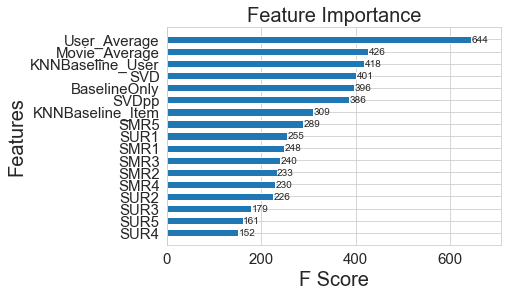

In [216]:
x_train = Train_Reg.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

x_test = Test_Reg.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

y_train = Train_Reg["Rating"]

y_test = Test_Reg["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_BSL_KNN_MF")

model_train_evaluation["XGB_BSL_KNN_MF"] = train_result
model_test_evaluation["XGB_BSL_KNN_MF"] = test_result

## Summary


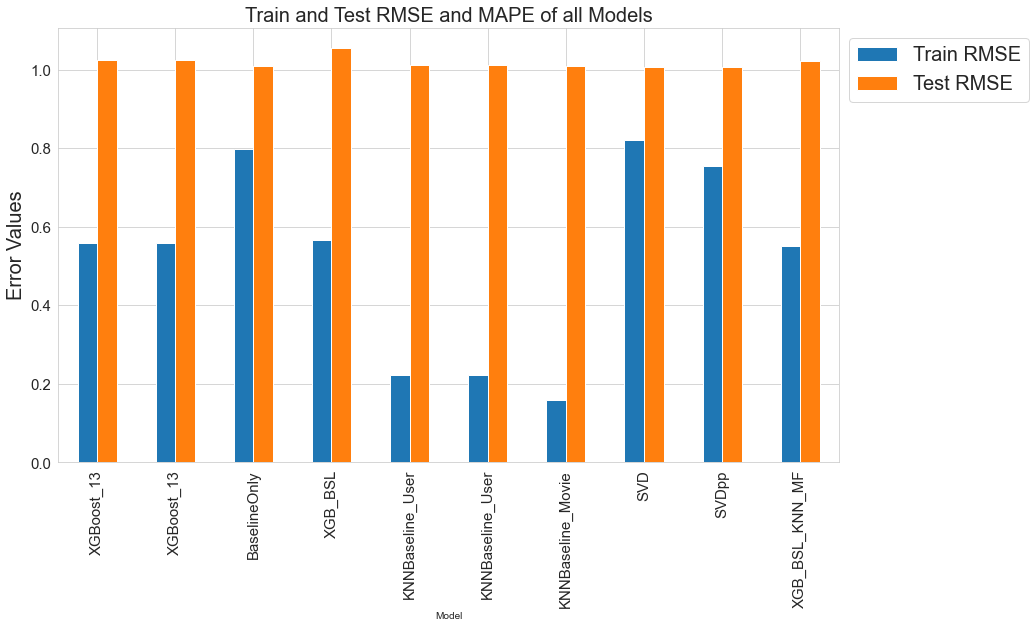

In [223]:
error_table[["Train RMSE","Test RMSE","Model"]].plot(x = "Model", kind = "bar", figsize = (14, 8), grid = True, fontsize = 15)
plt.title("Train and Test RMSE and MAPE of all Models", fontsize = 20)
plt.ylabel("Error Values", fontsize = 20)
plt.legend(bbox_to_anchor=(1, 1), fontsize = 20)
plt.show()

In [224]:
error_table.drop(["Train MAPE", "Test MAPE"], axis = 1).style.highlight_min(axis=0)

,Model,Train RMSE,Test RMSE
0,XGBoost_13,0.559476,1.023453
1,XGBoost_13,0.559476,1.023453
2,BaselineOnly,0.798157,1.008688
3,XGB_BSL,0.566091,1.054523
4,KNNBaseline_User,0.223815,1.011101
5,KNNBaseline_User,0.223815,1.011101
6,KNNBaseline_Movie,0.160042,1.008476
7,SVD,0.820489,1.006636
8,SVDpp,0.754885,1.007090
9,XGB_BSL_KNN_MF,0.551480,1.021945


# So, Here our Best Model is SVD with the least Test RMSE